In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.patches as patches

# imports the permutation function to generate all permutations of 2 of the FANG stocks
from itertools import permutations
# imports test for Granger Causality (does variable x have value in predicting y)
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.api import VAR

In [2]:
plt.style.use('../HighFrequencyTrading/MNRAS_stylesheet')

In [3]:
GDP_growth = pd.read_csv('./VARmodel/quarterly_gdp_growth_y2y.csv').set_index(['Subject','Measure','Country','TIME']).loc['Gross domestic product - expenditure approach'].loc['Growth rate compared to the same quarter of previous year, seasonally adjusted'].loc['Netherlands']#[['Value']]
GDP_growth = GDP_growth[['Value']]
GDP_growth.columns=['GDPGrowth']
GDP_growth.index = pd.to_datetime(GDP_growth.index)

In [4]:
gov_spending = pd.read_csv('./VARmodel/govspending.csv')
gov_spending = gov_spending.set_index('LOCATION').loc['NLD'].set_index('TIME')[['Value']].astype(float)
gov_spending.index = pd.to_datetime(gov_spending.index,format='%Y')
gov_spending.columns = ['GovSpending']

In [5]:
quarterly_debt = pd.read_excel('./VARmodel/quarterlydebt.xlsx')
quarterly_debt = quarterly_debt.set_index(['Country Name','Indicator Name']).loc['Netherlands'].loc['Gross PSD, Budgetary Central Gov., All maturities, All instruments, Nominal Value, % of GDP'].dropna()
quarterly_debt = pd.DataFrame(quarterly_debt).iloc[2:]
quarterly_debt.columns = ['Debt']
quarterly_debt.index = pd.to_datetime(quarterly_debt.index)

In [6]:
deficit = pd.read_csv('./VARmodel/deficit',header=None)
deficit.columns = ['Year','col1','deficit']
deficit = deficit.set_index('Year').sort_index()
deficit = deficit[['deficit']]

In [7]:
inflation = pd.read_csv('./VARmodel/inflation_y2y.csv').set_index(['Country','Subject','TIME']).loc['Netherlands'].loc['CPI: 01-12 - All items']
inflation = inflation[['Value']].iloc[:-1]
inflation.columns = ['Inflation']
inflation.index = pd.to_datetime(inflation.index)

In [8]:
interest_rate = pd.read_csv('./VARmodel/interest_rate.csv').set_index(['Country','TIME'])[['Value']].loc['Netherlands']
interest_rate = interest_rate.iloc[:-1]
interest_rate.columns = ['InterestRate']
interest_rate.index = pd.to_datetime(interest_rate.index)

In [9]:
debt = pd.DataFrame(pd.read_excel('./VARmodel/debtNL.xls').iloc[0,1:])
debt.columns = ['debt']
#debt.index = pd.to_datetime(debt.index,format='%Y')
debt = debt.iloc[30:]


<h3>VAR model debt</h3>

In [10]:
GDP_growth_annual = GDP_growth.resample('1Y').mean()
GDP_growth_annual.index = [int(w.strftime('%Y')) for w in GDP_growth_annual.index]
inflation_annual  = inflation.resample('1Y').mean()
inflation_annual.index = [int(w.strftime('%Y')) for w in inflation_annual.index]
interest_rate_annual = interest_rate.resample('1Y').mean()
interest_rate_annual.index = [int(w.strftime('%Y')) for w in interest_rate_annual.index]

In [11]:
df = deficit.join(debt).join(GDP_growth_annual).join(inflation_annual)#.join(interest_rate_annual)
df.loc[2019,'debt'] = 48.1
df.index = pd.to_datetime(df.index,format='%Y')
#df = pd.concat((df.iloc[:15],df.iloc[16:]))
df = df.iloc[15:]
df = df.astype(float)
#df = df.join(gov_spending)


In [12]:
model = VAR(df)#, dates=df.index)
results = model.fit(3,trend='nc')
results.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Jan, 2021
Time:                     16:26:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.98955
Nobs:                     22.0000    HQIC:                   3.16986
Log likelihood:          -105.567    FPE:                    23.1169
AIC:                      2.60910    Det(Omega_mle):         4.05232
--------------------------------------------------------------------
Results for equation deficit
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
L1.deficit           0.845605         0.246687            3.428           0.001
L1.debt             -0.304068         0.069728           -4.361           0.000
L1.GDPGrowth        -0.484104         0.227003           -2.13

/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


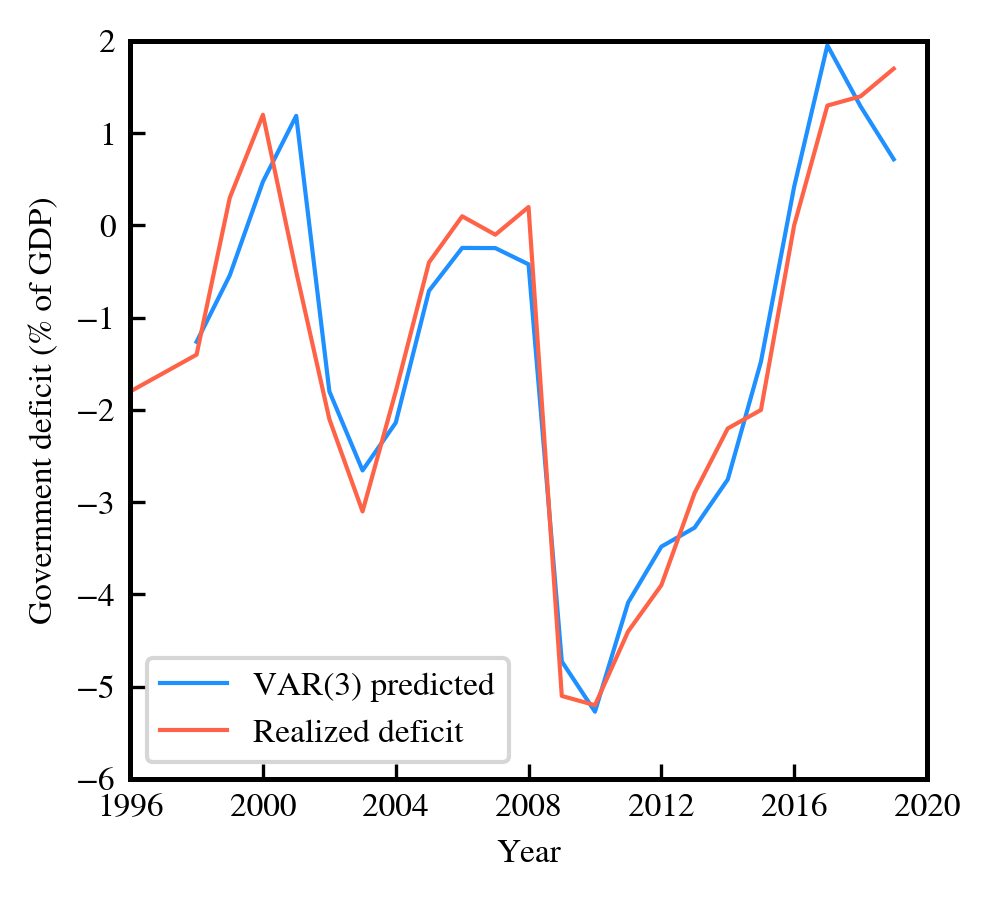

In [13]:
fig,ax = plt.subplots()

ax.plot(results.fittedvalues.deficit.index,results.fittedvalues.deficit.values,label='VAR(3) predicted',color='dodgerblue',lw=1)
ax.plot(df.deficit.index, df.deficit,label='Realized deficit',color='tomato',lw=1)
plt.legend(frameon=True)
plt.xlabel('Year')
plt.ylabel('Government deficit (% of GDP)')
plt.tight_layout()
plt.ylim(-6,2)
plt.xlim(datetime.date(1996,1,1),datetime.date(2020,1,1))
plt.savefig('Gov_deficit_VAR3.pdf',bbox_inches='tight')

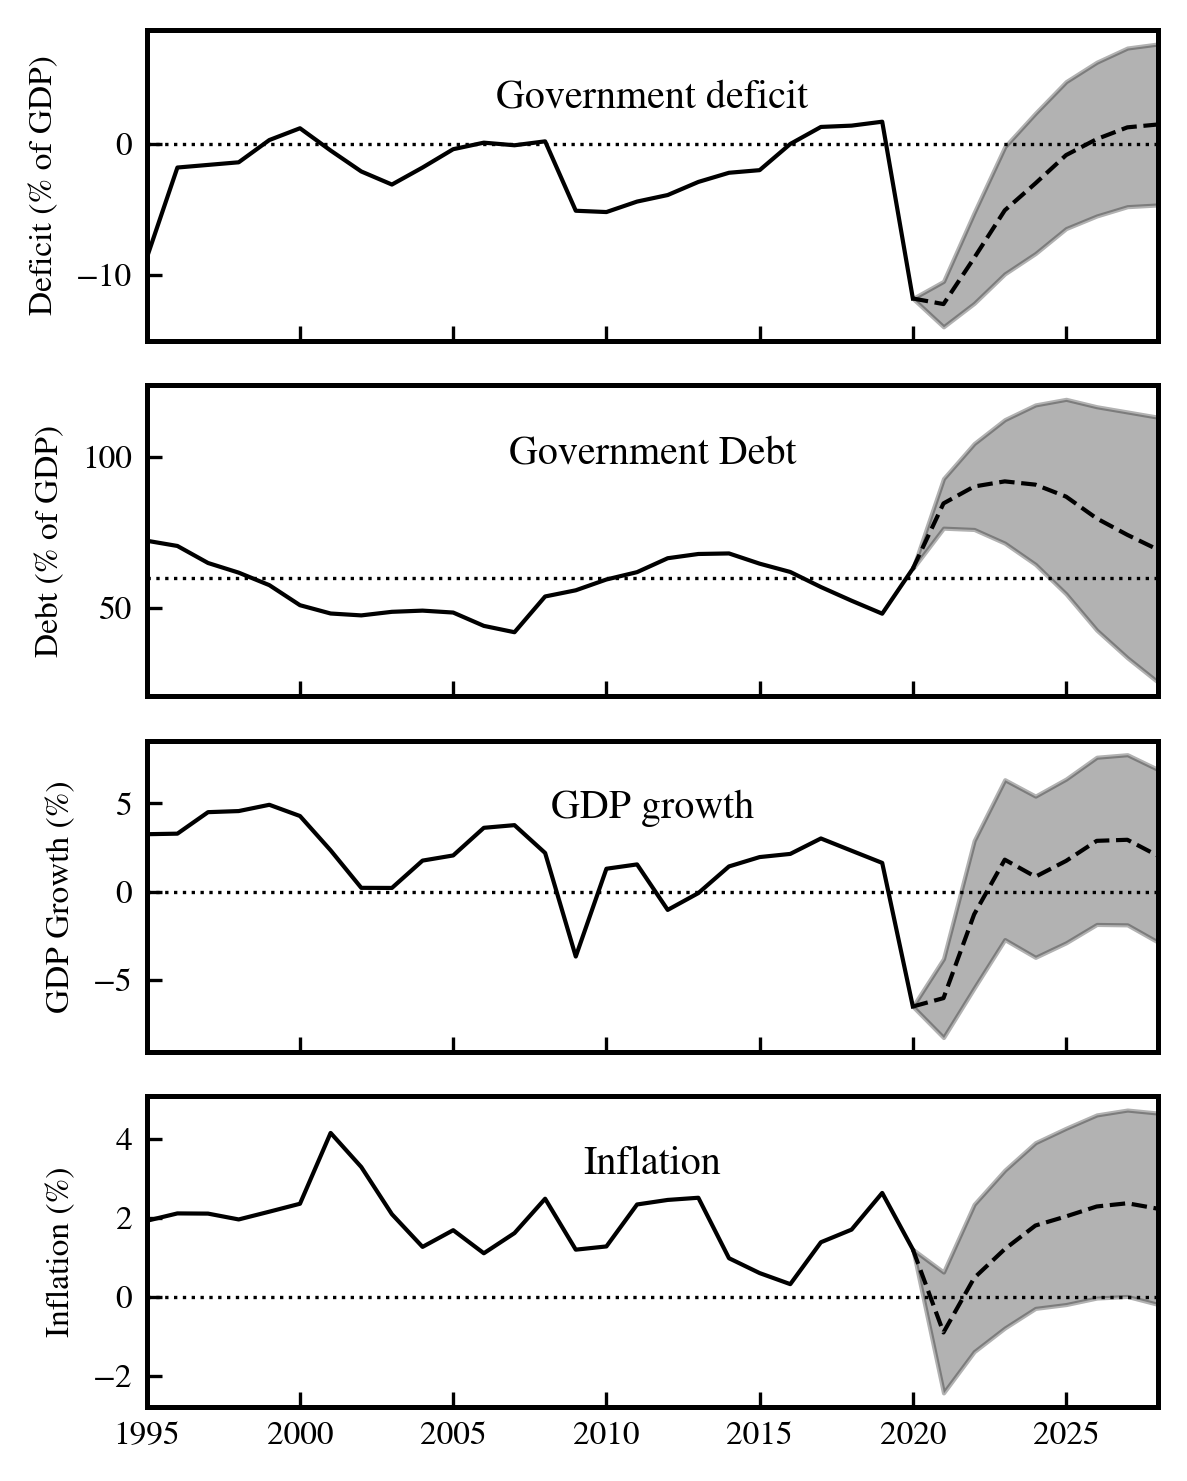

In [26]:
Xnew = np.vstack((df.iloc[-3:].values,np.array([-11.8,63,-6.5,1.2])))
Nsteps=8
predictions = results.forecast(y=Xnew,steps=Nsteps)
predictions_interval = results.forecast_interval(y=Xnew,steps=Nsteps)

data = np.vstack((df.values,np.array([-11.8,63,-6.5,1.2]),predictions))

lowerbound = np.vstack((np.array([-11.8,63,-6.5,1.2]),predictions_interval[1]))
upperbound = np.vstack((np.array([-11.8,63,-6.5,1.2]),predictions_interval[2]))


times = np.arange(1995,2020+Nsteps+1,1)

fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4,figsize=(4,5))
ax1.plot(times[:-Nsteps],data[:,0][:-Nsteps],color='black',lw=1)
ax1.plot(times[-Nsteps-1:],data[:,0][-Nsteps-1:],ls='--',color='black',lw=1)
ax1.set_xticklabels(len(ax1.get_xticks())*[''])
ax1.fill_between(times[-Nsteps-1:],lowerbound[:,0],upperbound[:,0],color='black',alpha=0.3)
ax1.set_title('Government deficit',y=0.67)
ax1.axhline(0,ls='dotted',lw=0.8,color='black')
ax1.set_xlim(1995,2028)
ax1.set_ylabel('Deficit (% of GDP)')

ax2.plot(times[:-Nsteps],data[:,1][:-Nsteps],color='black',lw=1)
ax2.plot(times[-Nsteps-1:],data[:,1][-Nsteps-1:],ls='--',color='black',lw=1)
ax2.set_xticklabels(len(ax1.get_xticks())*[''])
ax2.fill_between(times[-Nsteps-1:],lowerbound[:,1],upperbound[:,1],color='black',alpha=0.3)
ax2.set_title('Government Debt',y=0.67)
ax2.axhline(60,ls='dotted',lw=0.8,color='black')
ax2.set_xlim(1995,2028)
ax2.set_ylabel('Debt (% of GDP)')

ax3.plot(times[:-Nsteps],data[:,2][:-Nsteps],color='black',lw=1)
ax3.plot(times[-Nsteps-1:],data[:,2][-Nsteps-1:],ls='--',color='black',lw=1)
ax3.set_xticklabels(len(ax1.get_xticks())*[''])
ax3.fill_between(times[-Nsteps-1:],lowerbound[:,2],upperbound[:,2],color='black',alpha=0.3)
ax3.set_title('GDP growth',y=0.67)
ax3.axhline(0,ls='dotted',lw=0.8,color='black')
ax3.set_xlim(1995,2028)
ax3.set_ylabel('GDP Growth (%)')

ax4.plot(times[:-Nsteps],data[:,3][:-Nsteps],color='black',lw=1)
ax4.plot(times[-Nsteps-1:],data[:,3][-Nsteps-1:],ls='--',color='black',lw=1)
ax4.fill_between(times[-Nsteps-1:],lowerbound[:,3],upperbound[:,3],color='black',alpha=0.3)
ax4.set_title('Inflation',y=0.67)
ax4.axhline(0,ls='dotted',lw=0.8,color='black')
ax4.set_xlim(1995,2028)
ax4.set_ylabel('Inflation (%)')

plt.tight_layout()
plt.savefig('VARpredictions_future.pdf',bbox_inches='tight')

<h3>VAR model quarterly</h3>

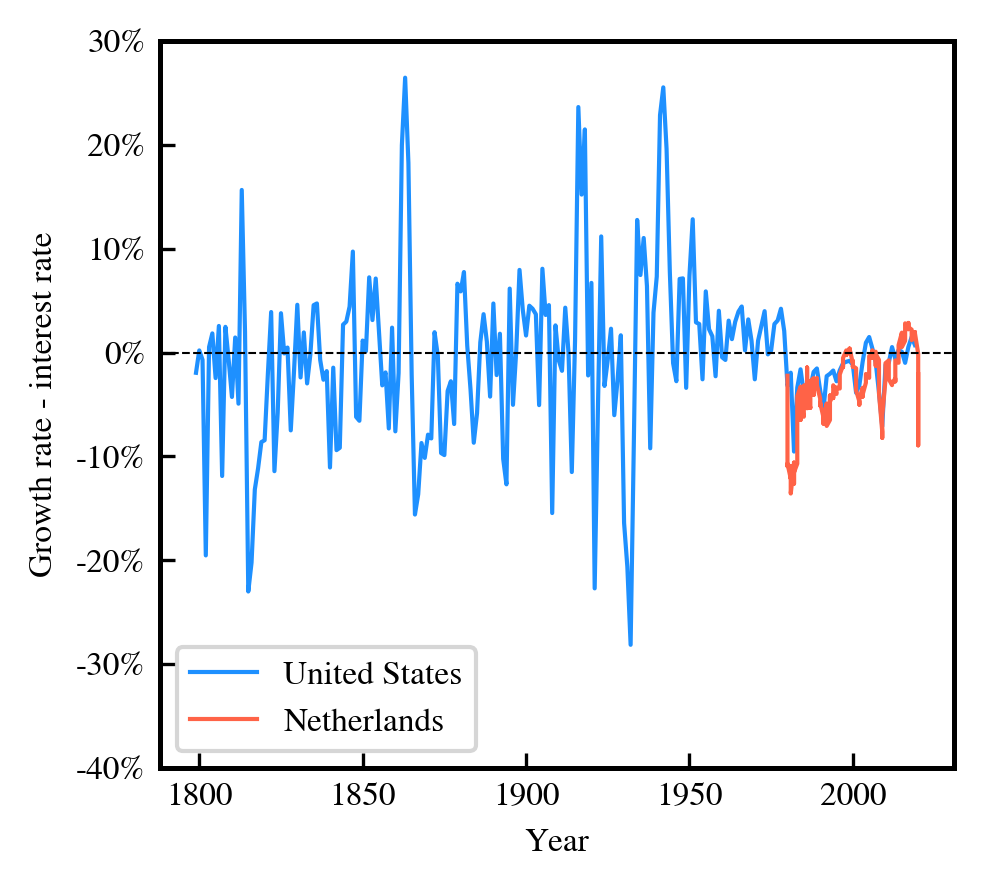

In [33]:
historical_GDP = pd.read_csv('US_historical_gdp.csv').set_index('Year')
historical_interest = pd.read_csv('US_interestrates_historical.csv').set_index('Year')
historical_GDP

historical_interest = historical_interest['US Long-Term Rate: Consistent Series']
historical_GDP = historical_GDP['Nominal GDP (million of Dollars)'].pct_change()*100

plt.figure()#figsize=(6.6,2.4))
plt.plot(historical_GDP - historical_interest,lw=1,color='dodgerblue',label='United States')


growth_interest = GDP_growth.join(interest_rate)
plt.plot([float(w.strftime('%Y')) for w in growth_interest.index],growth_interest['GDPGrowth'] - growth_interest['InterestRate'],lw=1,color='tomato',label='Netherlands')
plt.axhline(0,ls='--',color='black',lw=0.5)
plt.legend(frameon=1)

plt.yticks(plt.yticks()[0],labels=[str(int(w))+'%' for w in plt.yticks()[0]])
plt.ylabel('Growth rate - interest rate')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('historical_growthmininterest.pdf',bbox_inches='tight')

In [34]:
df = GDP_growth.join(inflation).join(interest_rate).join(quarterly_debt)
df.index = pd.to_datetime(df.index)
#df = df.iloc[76:-4]
df = df.dropna()
df = df.astype(float)
df = df.iloc[:-2]
df

GDPGrowth  Inflation  InterestRate       Debt
TIME                                                     
1995-10-01   2.995966   1.530312      6.343333  59.229488
1996-10-01   3.683802   2.313876      5.786667  58.163801
1997-10-01   4.956983   2.356611      5.466667  54.507026
1998-10-01   3.887742   1.767795      4.093333  53.675547
1999-10-01   5.680132   2.064231      5.304000  51.806494
...               ...        ...           ...        ...
2018-10-01   1.699210   2.031750      0.500000  53.098695
2019-01-01   1.749510   2.540770      0.240000  52.204057
2019-04-01   1.500378   2.658011      0.073333  53.513722
2019-07-01   1.611572   2.667690     -0.380000  51.795790
2019-10-01   1.659041   2.666795     -0.213333  49.759518

[85 rows x 4 columns]

In [35]:
(growth_interest['GDPGrowth'] - growth_interest['InterestRate']).iloc[80:].mean()

-1.345523306068273

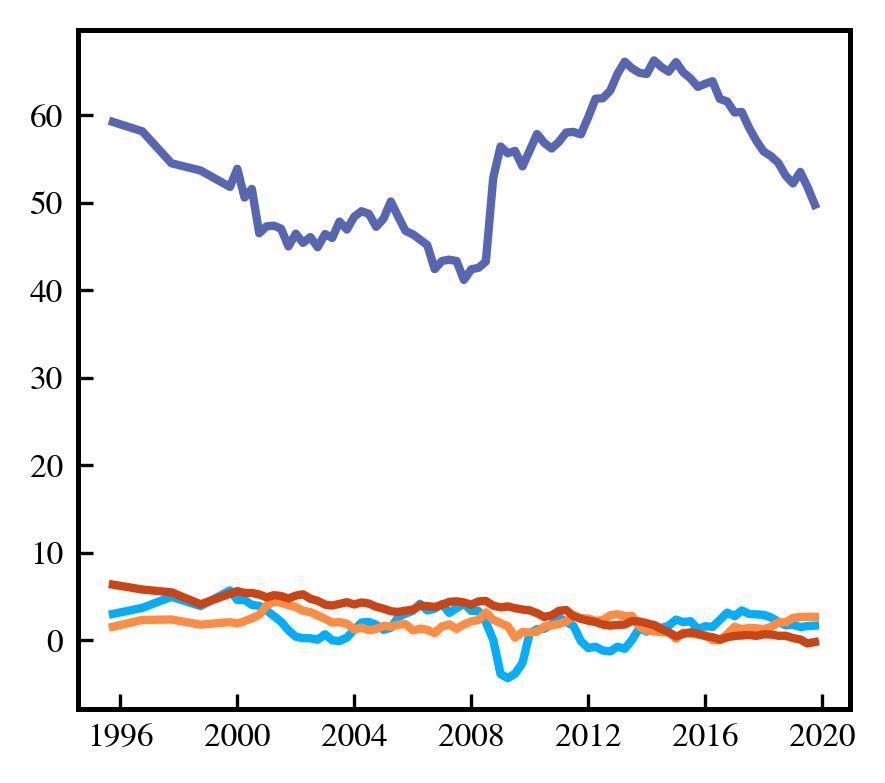

In [36]:
plt.plot(df.index, df.GDPGrowth)
plt.plot(df.index, df.Inflation)
plt.plot(df.index, df.InterestRate)
plt.plot(df.index, df.Debt)

In [37]:
model = VAR(df)#, dates=df.index)
var_results = model.fit(4,trend='nc')
var_results.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Jan, 2021
Time:                     16:45:44
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -1.88705
Nobs:                     81.0000    HQIC:                  -3.01990
Log likelihood:          -242.688    FPE:                  0.0233324
AIC:                     -3.77896    Det(Omega_mle):       0.0113452
--------------------------------------------------------------------
Results for equation GDPGrowth
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
L1.GDPGrowth            0.689753         0.136270            5.062           0.000
L1.Inflation           -0.286890         0.189263           -1.516           0.130
L1.InterestRate         0.074548         0.27970

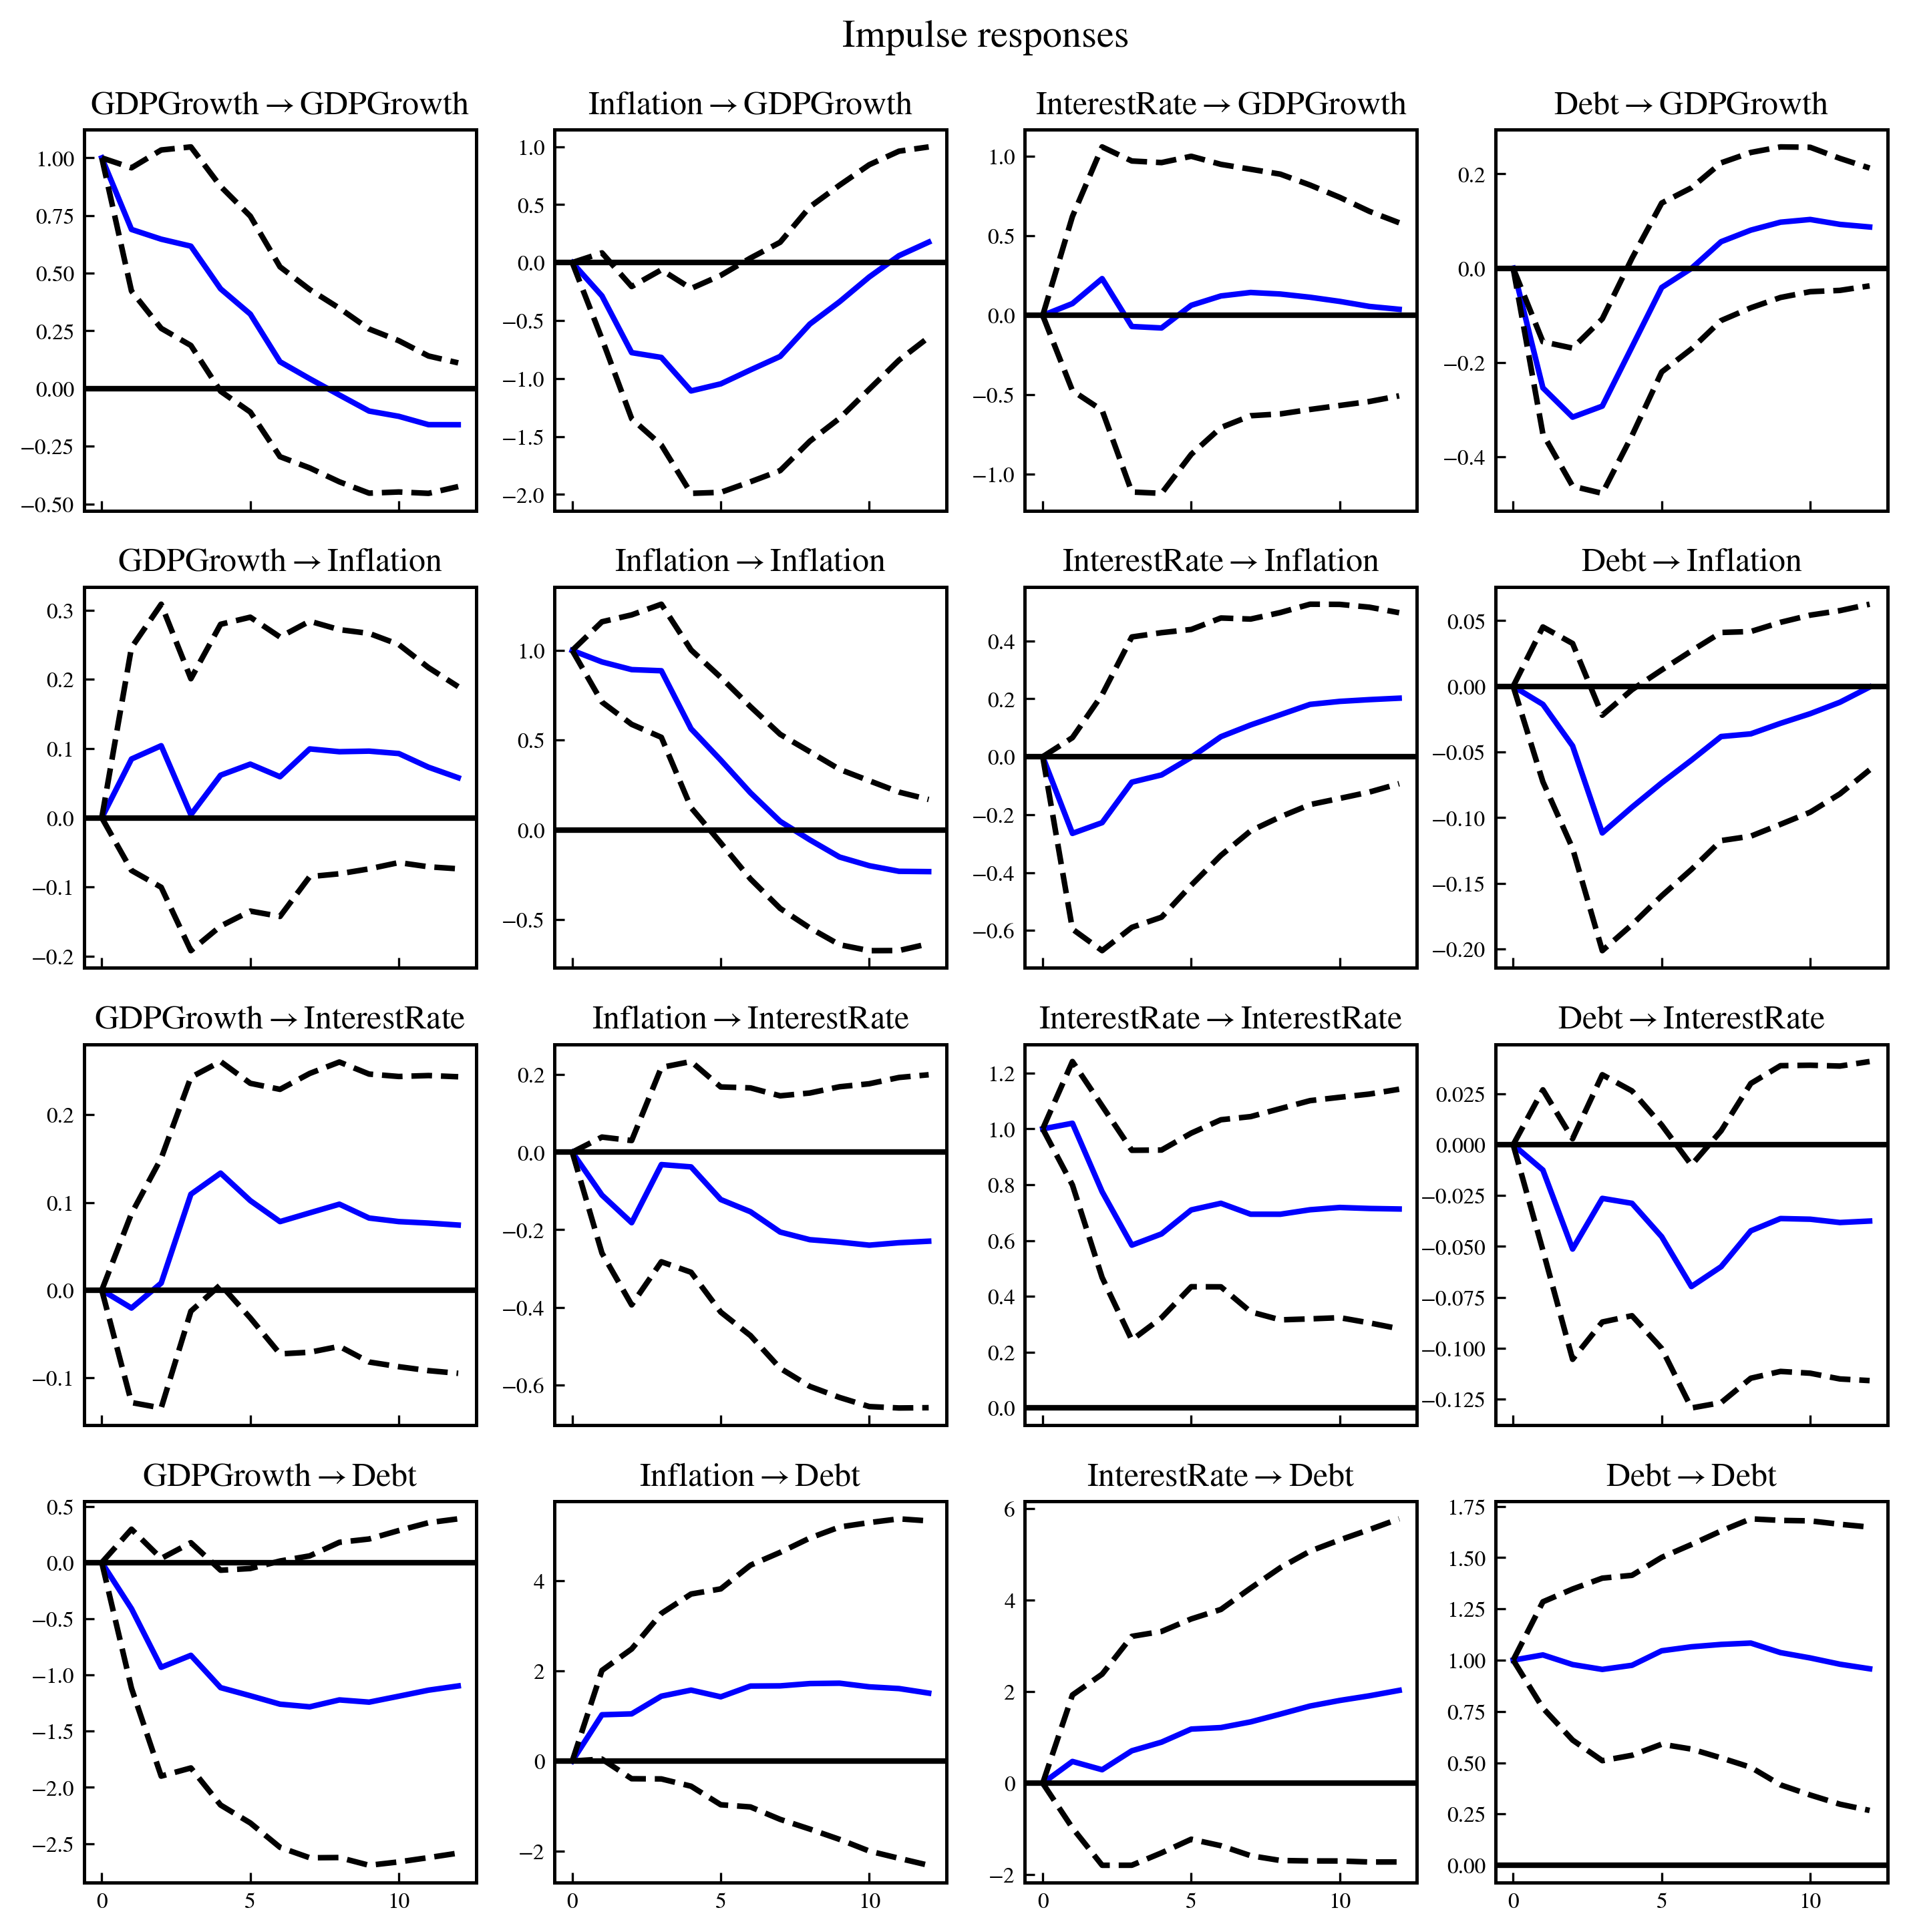

In [40]:
num_periods = 12
ir = var_results.irf(periods=num_periods)
ir.plot(plot_stderr=True)
plt.savefig('VAR_IRF.pdf')

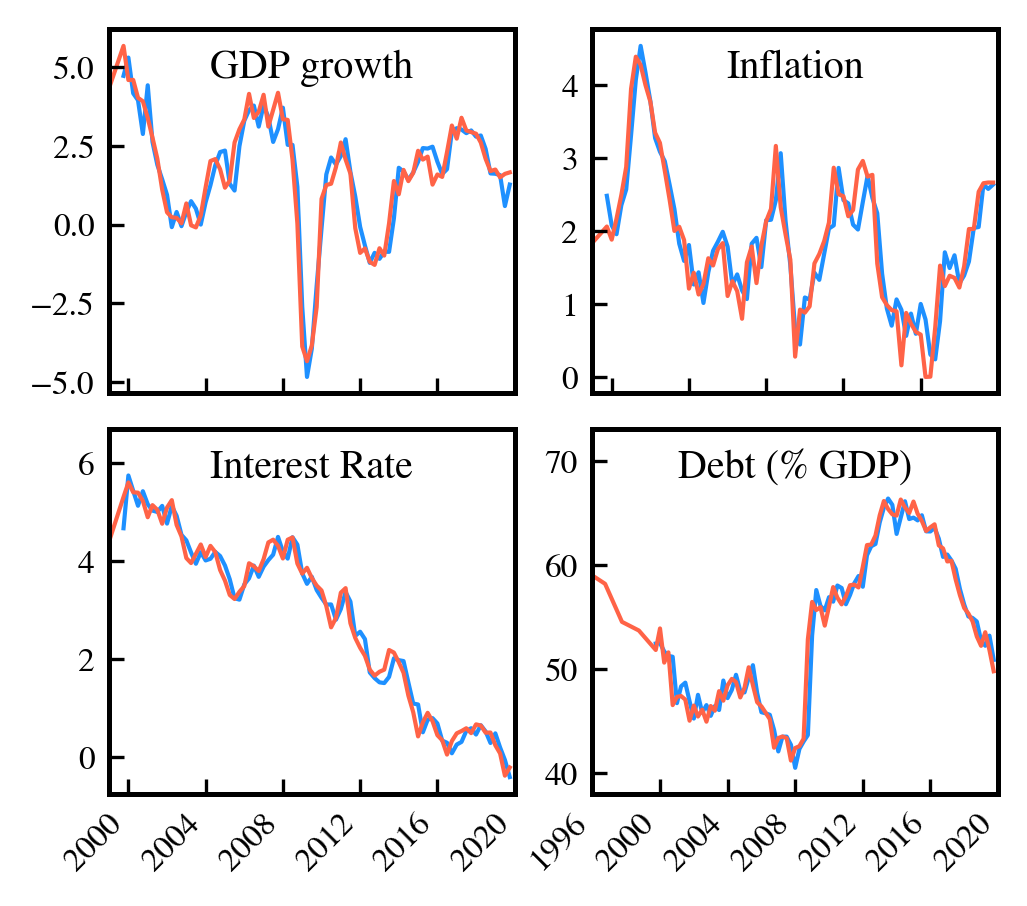

In [41]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2)

ax1.plot(var_results.fittedvalues.GDPGrowth.index,var_results.fittedvalues.GDPGrowth.values,label='VAR prediction',color='dodgerblue',lw=1)
ax1.plot(df.GDPGrowth.index, df.GDPGrowth,label='Realized',color='tomato',lw=1)
ax1.set_xticklabels(len(ax1.get_xticks())*[''])
ax1.set_title('GDP growth',y=0.8)
ax1.set_xlim(datetime.date(1999,1,1),datetime.date(2020,1,1))

ax2.plot(var_results.fittedvalues.Inflation.index,var_results.fittedvalues.Inflation.values,label='VAR prediction',color='dodgerblue',lw=1)
ax2.plot(df.Inflation.index, df.Inflation,label='Realized',color='tomato',lw=1)
ax2.set_xticklabels(len(ax2.get_xticks())*[''])
ax2.set_title('Inflation',y=0.8)
ax2.set_xlim(datetime.date(1999,1,1),datetime.date(2020,1,1))

ax3.plot(var_results.fittedvalues.InterestRate.index,var_results.fittedvalues.InterestRate.values,label='VAR prediction',color='dodgerblue',lw=1)
ax3.plot(df.InterestRate.index, df.InterestRate,label='Realized',color='tomato',lw=1)
#ax3.set_xticklabels(len(ax3.get_xticks())*[''])
ax3.set_title('Interest Rate',y=0.8)
ax3.set_xlim(datetime.date(1999,1,1),datetime.date(2020,1,1))
fig.autofmt_xdate()

ax4.plot(var_results.fittedvalues.Debt.index,var_results.fittedvalues.Debt.values,label='VAR prediction',color='dodgerblue',lw=1)
ax4.plot(df.Debt.index, df.Debt,label='Realized',color='tomato',lw=1)
ax4.set_title('Debt (% GDP)',y=0.8)
ax4.set_ylim(38,73)
ax4.set_xlim(datetime.date(1999,1,1),datetime.date(2020,1,1))
fig.autofmt_xdate(rotation=45)

#plt.legend(frameon=True)
#plt.xlabel('Year')
#plt.ylabel('Government deficit (% of GDP)')
plt.tight_layout(pad=0.8)
#plt.ylim(-6,2)
plt.xlim(datetime.date(1996,1,1),datetime.date(2020,1,1))
plt.savefig('2x2VARpredictions.pdf',bbox_inches='tight')

<h3>VECM</h3>

In [42]:
from statsmodels.tsa.vector_ar.vecm import *

In [43]:
lag_order = select_order(data=df, maxlags=7, deterministic="nc", seasons=0)
lag_order.summary()


/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been pro

<class 'statsmodels.iolib.table.SimpleTable'>

In [44]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic


(1, 0, 1, 1)

In [45]:
rank_test = select_coint_rank(df, 0, 1, method="trace",
                              signif=0.05)
rank_test.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [46]:
df

GDPGrowth  Inflation  InterestRate       Debt
TIME                                                     
1995-10-01   2.995966   1.530312      6.343333  59.229488
1996-10-01   3.683802   2.313876      5.786667  58.163801
1997-10-01   4.956983   2.356611      5.466667  54.507026
1998-10-01   3.887742   1.767795      4.093333  53.675547
1999-10-01   5.680132   2.064231      5.304000  51.806494
...               ...        ...           ...        ...
2018-10-01   1.699210   2.031750      0.500000  53.098695
2019-01-01   1.749510   2.540770      0.240000  52.204057
2019-04-01   1.500378   2.658011      0.073333  53.513722
2019-07-01   1.611572   2.667690     -0.380000  51.795790
2019-10-01   1.659041   2.666795     -0.213333  49.759518

[85 rows x 4 columns]

In [47]:
model = VECM(df, deterministic="nc", seasons=0,
             k_ar_diff=3,#lag_order.aic,  
             coint_rank=rank_test.rank)
vecm_res = model.fit()
vecm_res.summary()

/home/luuk/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation GDPGrowth
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.GDPGrowth        0.0885      0.096      0.925      0.355      -0.099       0.276
L1.Inflation        0.0741      0.178      0.416      0.678      -0.275       0.423
L1.InterestRate    -0.0725      0.236     -0.308      0.758      -0.534       0.389
L1.Debt            -0.2696      0.045     -5.955      0.000      -0.358      -0.181
L2.GDPGrowth        0.1838      0.093      1.973      0.048       0.001       0.366
L2.Inflation        0.0437      0.183      0.239      0.811      -0.315       0.403
L2.InterestRate     0.0705      0.234      0.301      0.763      -0.388       0.529
L2.Debt            -0.1512      0.053     -2.877      0.004      -0.254      -0.048
L3.GDPGrowth        0.1318      0.090      1.459      0.145      -0.045       0.309
L3.Inflation        0.2546      0.177      1.442      0.149      -0.091       0.601
L3.InterestRate    -0.4137      0.220     -1.884      0.060      -0.844       0.017
L3.Debt            -0.0787      0.050     -1.567      0.117      -0.177       0.020
Det. terms outside the coint. relation & lagged endog. parameters for equation Inflation
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.GDPGrowth        0.0811      0.062      1.313      0.189      -0.040       0.202
L1.Inflation        0.0208      0.115      0.181      0.856      -0.204       0.246
L1.InterestRate    -0.2461      0.152     -1.619      0.105      -0.544       0.052
L1.Debt            -0.0242      0.029     -0.828      0.408      -0.081       0.033
L2.GDPGrowth        0.0665      0.060      1.108      0.268      -0.051       0.184
L2.Inflation        0.0735      0.118      0.622      0.534      -0.158       0.305
L2.InterestRate     0.0148      0.151      0.098      0.922      -0.281       0.311
L2.Debt            -0.0270      0.034     -0.796      0.426      -0.093       0.039
L3.GDPGrowth       -0.0538      0.058     -0.924      0.356      -0.168       0.060
L3.Inflation        0.1666      0.114      1.463      0.143      -0.057       0.390
L3.InterestRate     0.0242      0.142      0.171      0.864      -0.253       0.302
L3.Debt            -0.0677      0.032     -2.091      0.037      -0.131      -0.004
Det. terms outside the coint. relation & lagged endog. parameters for equation InterestRate
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.GDPGrowth       -0.0409      0.041     -1.005      0.315      -0.121       0.039
L1.Inflation       -0.1079      0.076     -1.424      0.155      -0.256       0.041
L1.InterestRate     0.1073      0.100      1.070      0.284      -0.089       0.304
L1.Debt            -0.0109      0.019     -0.566      0.572      -0.049       0.027
L2.GDPGrowth        0.0203      0.040      0.512      0.609      -0.057       0.098
L2.Inflation       -0.0582      0.078     -0.747      0.455      -0.211       0.095
L2.InterestRate    -0.2176      0.100     -2.185      0.029      -0.413      -0.022
L2.Debt            -0.0484      0.022     -2.166      0.030      -0.092      -0.005
L3.GDPGrowth        0.0777      0.038      2.021      0.043       0.002       0.153
L3.Inflation        0.1706      0.075      2.271      0.023       0.023       0.318
L3.InterestRate    -0.1050      0.093     -1.124      0.261      -0.28

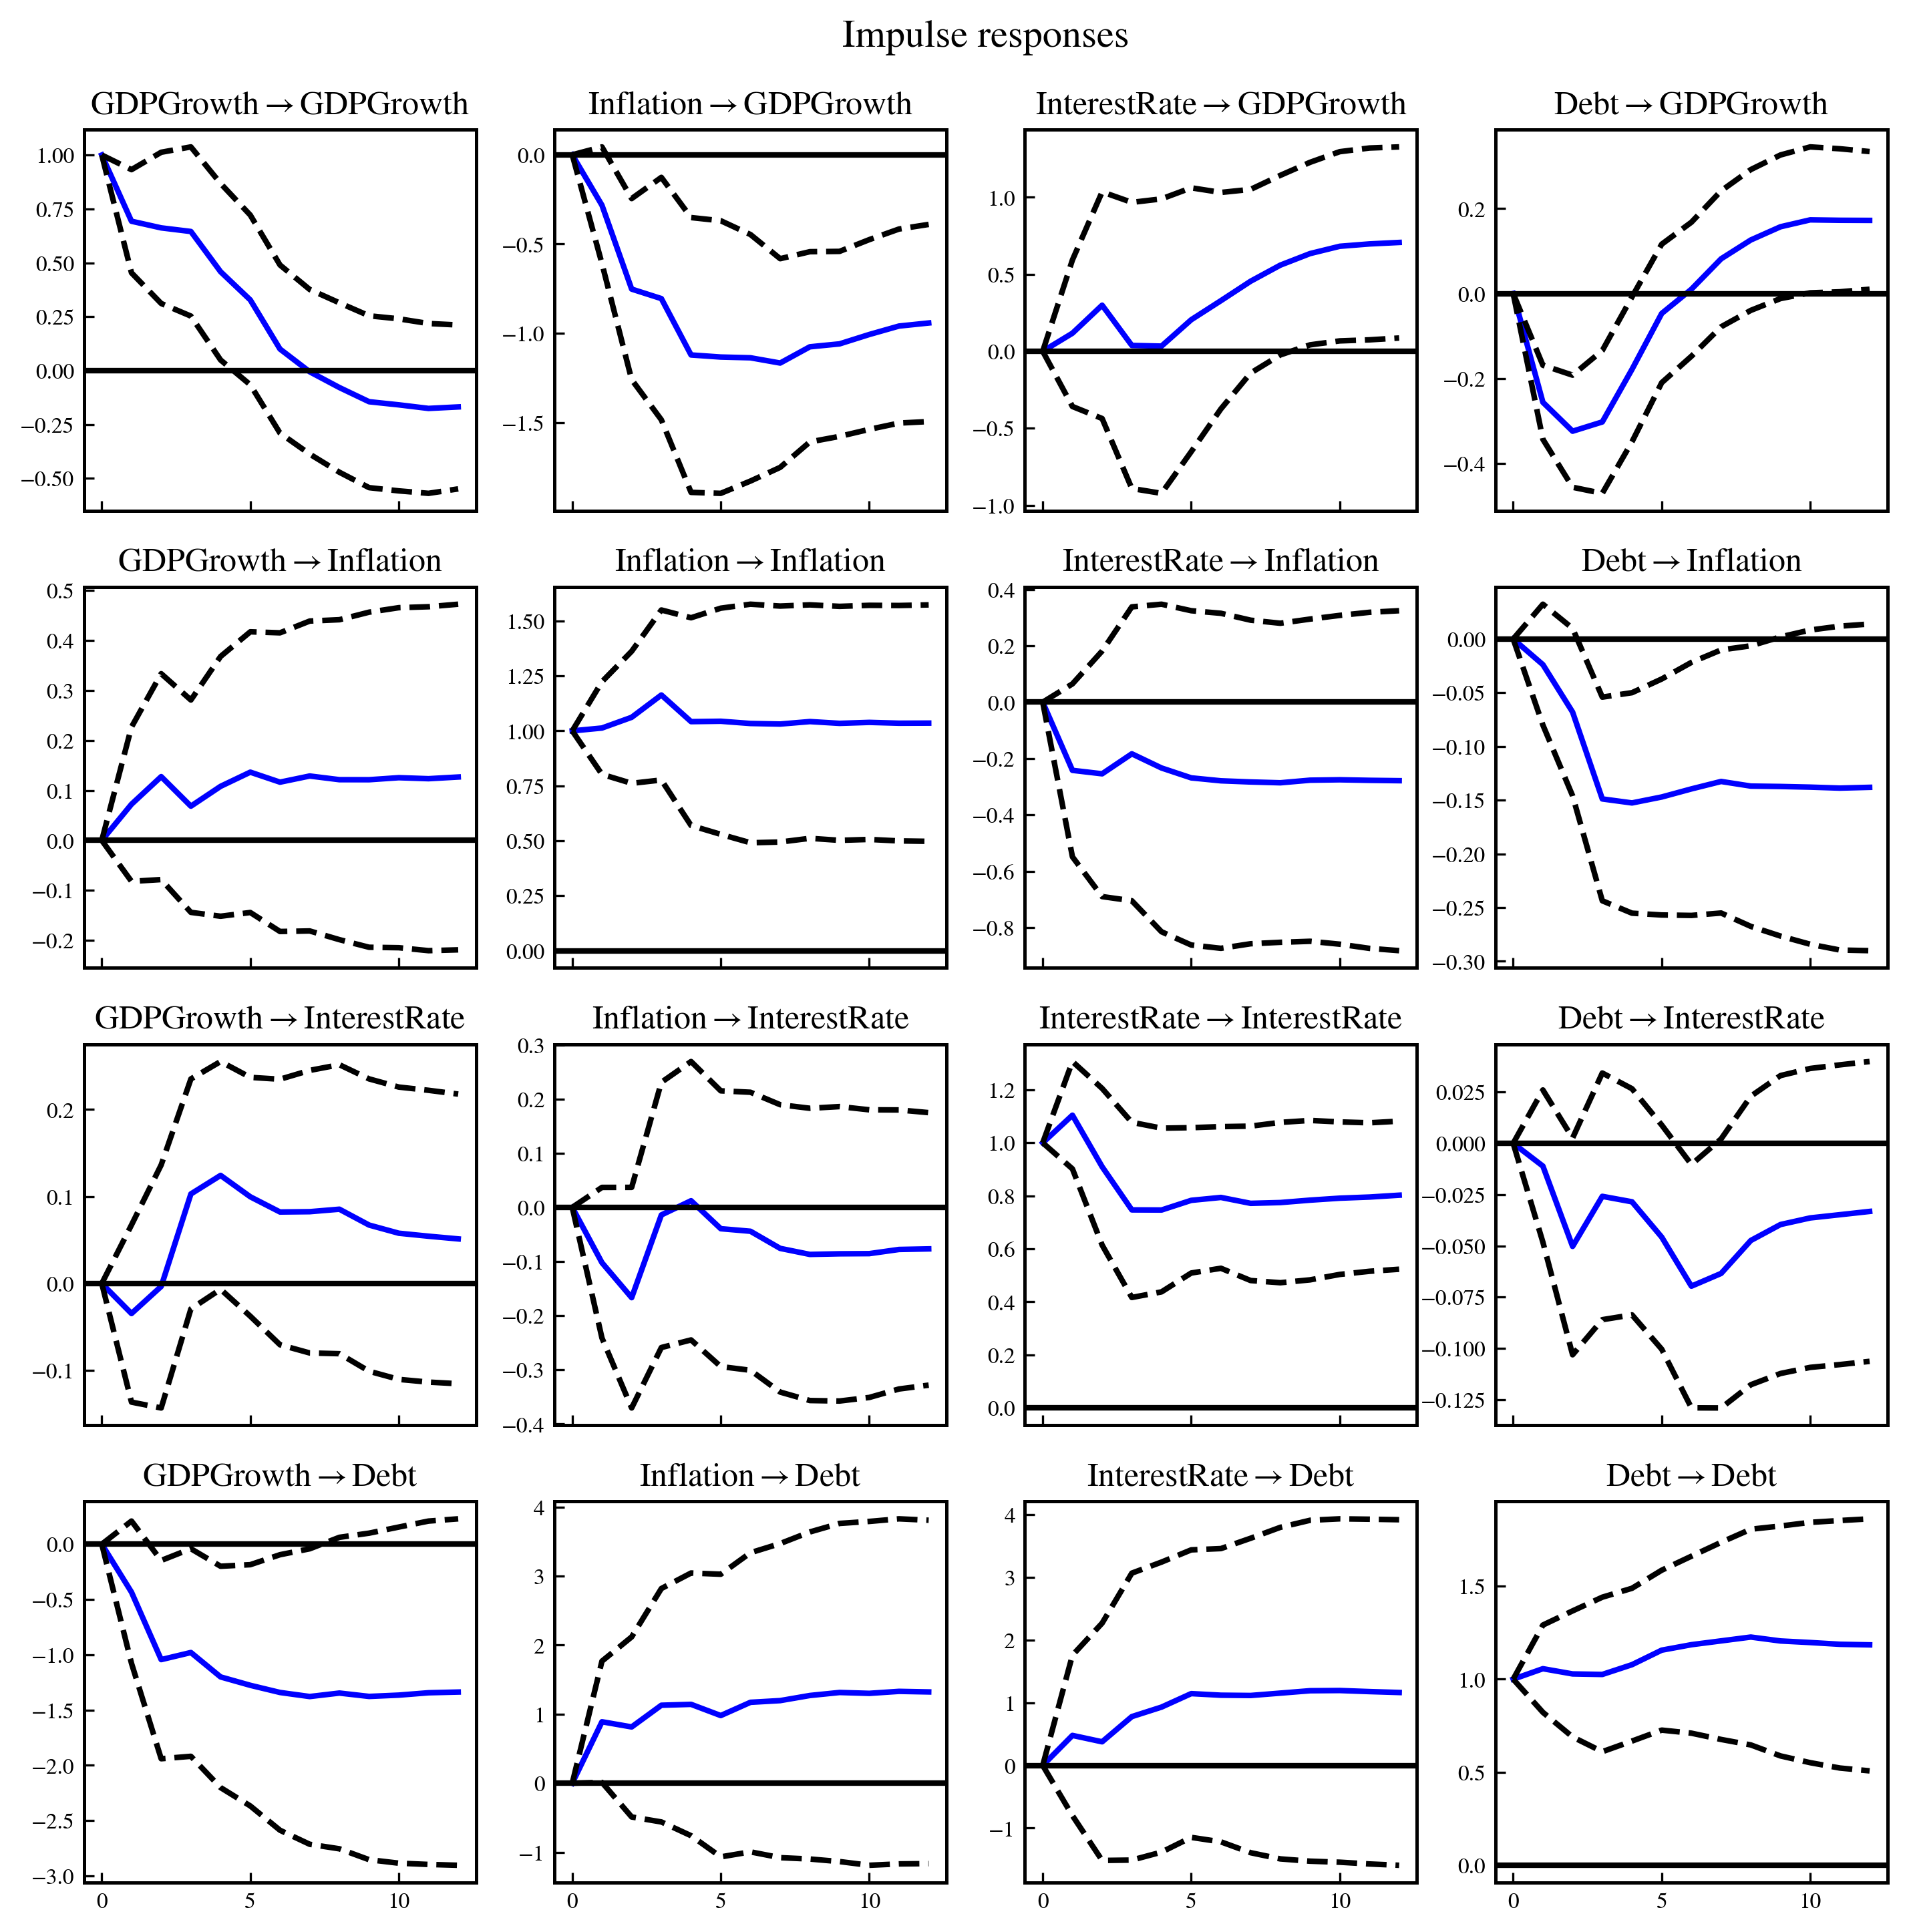

In [49]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
fig=ir.plot(plot_stderr=True)
plt.savefig('VECM_IRF.pdf')

In [33]:
for table in vecm_res.summary().tables[:4]:
    print(table.as_latex_tabular(),5*'\n')

\begin{center}
\begin{tabular}{lcccccc}
\toprule
                         & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{L1.GDPGrowth}    &       0.1346  &        0.094     &     1.438  &         0.150        &       -0.049    &        0.318     \\
\textbf{L1.Inflation}    &       0.0388  &        0.173     &     0.224  &         0.823        &       -0.300    &        0.378     \\
\textbf{L1.InterestRate} &       0.4963  &        0.260     &     1.907  &         0.057        &       -0.014    &        1.006     \\
\textbf{L1.Debt}         &      -0.2691  &        0.046     &    -5.807  &         0.000        &       -0.360    &       -0.178     \\
\textbf{L2.GDPGrowth}    &       0.2193  &        0.094     &     2.333  &         0.020        &        0.035    &        0.404     \\
\textbf{L2.Inflation}    &       0.1439  &        0.178     &     0.806  &         0.420        &       -0.206    &        0.49

In [50]:
for table in vecm_res.summary().tables[:5]:
    table = pd.DataFrame(table)
    table.columns = table.iloc[0,:]
    table = table.iloc[1:,:]
    table.columns = ['parameter','Coefficient','std err','z','P>|z|','[0.025','0.975]']
    table = table.set_index('parameter')
    for col in table.columns:
        table[col]= table[col].apply(lambda x: float(x.data))
    table = table[table['P>|z|']<0.1]
    print(table.to_latex(bold_rows=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  std err &      z &  P>|z| &  [0.025 &  0.975] \\
\textbf{parameter      } &              &          &        &        &         &         \\
\midrule
\textbf{L1.Debt        } &      -0.2696 &    0.045 & -5.955 &  0.000 &  -0.358 &  -0.181 \\
\textbf{L2.GDPGrowth   } &       0.1838 &    0.093 &  1.973 &  0.048 &   0.001 &   0.366 \\
\textbf{L2.Debt        } &      -0.1512 &    0.053 & -2.877 &  0.004 &  -0.254 &  -0.048 \\
\textbf{L3.InterestRate} &      -0.4137 &    0.220 & -1.884 &  0.060 &  -0.844 &   0.017 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  std err &      z &  P>|z| &  [0.025 &  0.975] \\
\textbf{parameter} &              &          &        &        &         &         \\
\midrule
\textbf{L3.Debt  } &      -0.0677 &    0.032 & -2.091 &  0.037 &  -0.131 &  -0.004 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &  std err &      z &  P>|z| &  [0.0

In [359]:
Xnew = np.vstack((df.iloc[-3:].values,np.array([-11.8,63,-6.5,1.2])))
Nsteps=8
predictions = vecm_res.predict(y=Xnew,steps=Nsteps)
predictions_interval = vecm_res.forecast_interval(y=Xnew,steps=Nsteps)

data = np.vstack((df.values,np.array([-11.8,63,-6.5,1.2]),predictions))

lowerbound = np.vstack((np.array([-11.8,63,-6.5,1.2]),predictions_interval[1]))
upperbound = np.vstack((np.array([-11.8,63,-6.5,1.2]),predictions_interval[2]))


times = np.arange(1980,2020+Nsteps+1,1)

fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4,figsize=(6,4))
ax1.plot(times[:-Nsteps],data[:,0][:-Nsteps],color='black',lw=1)
ax1.plot(times[-Nsteps-1:],data[:,0][-Nsteps-1:],ls='--',color='black',lw=1)
ax1.set_xticklabels(len(ax1.get_xticks())*[''])
ax1.fill_between(times[-Nsteps-1:],lowerbound[:,0],upperbound[:,0],color='black',alpha=0.3)
ax1.set_title('Government deficit',y=0.67)
ax1.axhline(0,ls='dotted',lw=0.8,color='black')
ax1.set_xlim(1995,2028)
ax1.set_ylabel('Deficit (% of GDP)')

ax2.plot(times[:-Nsteps],data[:,1][:-Nsteps],color='black',lw=1)
ax2.plot(times[-Nsteps-1:],data[:,1][-Nsteps-1:],ls='--',color='black',lw=1)
ax2.set_xticklabels(len(ax1.get_xticks())*[''])
ax2.fill_between(times[-Nsteps-1:],lowerbound[:,1],upperbound[:,1],color='black',alpha=0.3)
ax2.set_title('Government Debt',y=0.67)
ax2.axhline(60,ls='dotted',lw=0.8,color='black')
ax2.set_xlim(1995,2028)
ax2.set_ylabel('Debt (% of GDP)')

ax3.plot(times[:-Nsteps],data[:,2][:-Nsteps],color='black',lw=1)
ax3.plot(times[-Nsteps-1:],data[:,2][-Nsteps-1:],ls='--',color='black',lw=1)
ax3.set_xticklabels(len(ax1.get_xticks())*[''])
ax3.fill_between(times[-Nsteps-1:],lowerbound[:,2],upperbound[:,2],color='black',alpha=0.3)
ax3.set_title('GDP growth',y=0.67)
ax3.axhline(0,ls='dotted',lw=0.8,color='black')
ax3.set_xlim(1995,2028)
ax3.set_ylabel('GDP Growth (%)')

ax4.plot(times[:-Nsteps],data[:,3][:-Nsteps],color='black',lw=1)
ax4.plot(times[-Nsteps-1:],data[:,3][-Nsteps-1:],ls='--',color='black',lw=1)
ax4.fill_between(times[-Nsteps-1:],lowerbound[:,3],upperbound[:,3],color='black',alpha=0.3)
ax4.set_title('Inflation',y=0.67)
ax4.axhline(0,ls='dotted',lw=0.8,color='black')
ax4.set_xlim(1995,2028)
ax4.set_ylabel('Inflation (%)')

plt.tight_layout()
plt.savefig('VARpredictions_future.pdf',bbox_inches='tight')

AttributeError: 'VECMResults' object has no attribute 'forecast'

In [37]:
from astropy.io import ascii
quarterly_govdebt = ascii.read('./VARmodel/gov_10q_ggdebt.tsv').to_pandas()
quarterly_govdebt = quarterly_govdebt[quarterly_govdebt.iloc[:,0].str.contains('NL')]

In [152]:
quarterly_govdebt

na_item,sector,unit,geo\time\t2020Q2      2020Q1      2019Q4  \
24                   F2,S13,MIO_EUR,NL\t1408.0   p\t1073.0   p\t1689.0   
56                   F2,S13,MIO_NAC,NL\t1408.0   p\t1073.0   p\t1689.0   
88                       F2,S13,PC_GDP,NL\t0.2      p\t0.1      p\t0.2   
120                      F2,S13,PC_TOT,NL\t0.3      p\t0.3      p\t0.4   
152               F2,S1311,MIO_EUR,NL\t46799.0  p\t42464.0  p\t39266.0   
...                                        ...         ...         ...   
7024  IGL_F4_EU27_2020,S13,MIO_NAC,NL\t14182.3  p\t15592.3  p\t13892.3   
7055       IGL_F4_EU27_2020,S13,PC_GDP,NL\t1.8      p\t1.9      p\t1.7   
7086             IGL_F4_EU28,S13,MIO_EUR,NL\t:           :     13892.3   
7117             IGL_F4_EU28,S13,MIO_NAC,NL\t:           :     13892.3   
7148              IGL_F4_EU28,S13,PC_GDP,NL\t:           :         1.7   

       2019Q3   2019Q2   2019Q1   2018Q4   2018Q3   2018Q2   2018Q1  ...  \
24     2783.0   1844.0   1829.0   1608.0   1980.0   1592.0   1584.0  ...   
56     2783.0   1844.0   1829.0   1608.0   1980.0   1592.0   1584.0  ...   
88        0.3      0.2      0.2      0.2      0.3      0.2      0.2  ...   
120       0.7      0.5      0.5      0.4      0.5      0.4      0.4  ...   
152   48283.0  48366.0  34171.0  33206.0  41483.0  33791.0  30652.0  ...   
...       ...      ...      ...      ...      ...      ...      ...  ...   
7024  14014.9  14014.9  14014.9  14014.9  14014.9  14014.9  14014.9  ...   
7055      1.7      1.8      1.8      1.8      1.8      1.9      1.9  ...   
7086  14014.9  14014.9  14014.9  14014.9  14014.9  14014.9  14014.9  ...   
7117  14014.9  14014.9  14014.9  14014.9  14014.9  14014.9  14014.9  ...   
7148      1.7      1.8      1.8      1.8      1.8      1.9      1.9  ...   

     1998Q1 1997Q4 1997Q3 1997Q2 1997Q1 1996Q4 1996Q3 1996Q2 1996Q1 1995Q4  
24        :      :      :      :      :      :      :      :      :      :  
56        :      :      :      :      :      :      :      :      :      :  
88        :      :      :      :      :      :      :      :      :      :  
120       :      :      :      :      :      :      :      :      :      :  
152       :      :      :      :      :      :      :      :      :      :  
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
7024      :      :      :      :      :      :      :      :      :      :  
7055      :      :      :      :      :      :      :      :      :      :  
7086      :      :      :      :      :      :      :      :      :      :  
7117      :      :      :      :      :      :      :      :      :      :  
7148      :      :      :      :      :      :      :      :      :      :  

[359 rows x 99 columns]

TIME
1995-10-01   -3.347367
1996-10-01   -2.102864
1997-10-01   -0.509684
1998-10-01   -0.205591
1999-10-01    0.376132
                ...   
2019-04-01    1.427045
2019-07-01    1.991572
2019-10-01    1.872375
2020-01-01   -0.085231
2020-04-01   -8.927571
Length: 87, dtype: float64

In [132]:
pd.read_table('/home/luuk/Downloads/gov_10dd_edpt1.tsv')

unit,sector,na_item,geo\time     2019      2018      2017      2016   \
0              MIO_EUR,S1,B1GQ,AT  397575.3  385361.9  369341.3  357607.9   
1              MIO_EUR,S1,B1GQ,BE  476203.3  460419.4  444991.1  430085.3   
2              MIO_EUR,S1,B1GQ,BG   61239.5   56111.8   52329.0   48640.2   
3              MIO_EUR,S1,B1GQ,CY   22286.9   21432.4   20119.9   18929.3   
4              MIO_EUR,S1,B1GQ,CZ  223945.0  210892.7  194132.9  177438.5   
...                           ...       ...       ...       ...       ...   
2875           PC_GDP,S1314,GD,PT       0.0       0.0       0.0       0.0   
2876           PC_GDP,S1314,GD,RO       0.5       0.5       0.6       0.6   
2877           PC_GDP,S1314,GD,SE       0.4       0.6       0.6       0.6   
2878           PC_GDP,S1314,GD,SI       0.0       0.0       0.0       0.0   
2879           PC_GDP,S1314,GD,SK       0.0       0.0       0.0       0.0   

          2015       2014       2013       2012       2011   ...      2004   \
0     344269.2   333146.1   323910.2   318653.0   310128.7   ...  242348.3    
1     416701.4   403003.3   392880.0   386174.7   375967.8   ...  296819.7    
2      45690.9    42890.3    41903.5    42048.6    41268.9   ...   21093.2    
3      17884.0    17430.2    17995.0    19440.8    19803.0   ...   13937.9    
4     169558.2   157821.3   159461.6   162587.5   165202.2   ...   96554.1    
...         ...        ...        ...        ...        ...  ...        ...   
2875       0.0        0.0        0.0        0.0        0.0   ...       0.1    
2876       0.5        0.5        0.5        0.6        0.5   ...       1.1    
2877         :          :          :          :          :   ...         :    
2878       0.0        0.0        0.0        0.1        0.1   ...       0.7    
2879         :          :          :          :          :   ...         :    

          2003       2002       2001       2000       1999       1998   \
0     231862.5   226735.2   220525.1   213606.5   203850.6   195011.9    
1     281200.2   273255.9   264334.9   256376.4   242307.6   231015.7    
2      18798.3    17478.3    15905.3    14406.8    12804.4    13437.6    
3      12871.2    12082.9    11602.8    10804.5     9839.7     9152.5    
4      88659.5    87358.2    75705.2    67032.5    61082.9    59824.8    
...         ...        ...        ...        ...        ...        ...   
2875       0.1        0.0        0.2        0.0        0.1        0.0    
2876       1.4        1.8        2.3        2.2        3.2        4.7    
2877         :          :          :          :          :          :    
2878       0.7        0.6        0.6        0.5          :          :    
2879         :          :          :          :          :          :    

          1997       1996       1995   
0     187853.6   186968.1   184351.3   
1     223032.7   219965.3   220251.5   
2      10064.7     9829.9    14512.8   
3       8414.2     7890.1     7595.9   
4      54857.3    53088.1    46008.4   
...         ...        ...        ...  
2875       0.0        0.0        0.1   
2876       5.7       12.7       19.0   
2877         :          :          :   
2878         :          :          :   
2879         :          :          :   

[2880 rows x 26 columns]